In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import tensorflow as tf
from tqdm import tqdm
from IPython.display import clear_output
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Input, Dense, LSTM, Activation, GRU, LayerNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


In [31]:
train = pd.read_csv('/kaggle/input/asl-signs/train.csv')
parquet = pd.read_parquet(f'/kaggle/input/asl-signs/{train.path[0]}')
label_map = json.load(open('/kaggle/input/asl-signs/sign_to_prediction_index_map.json'))

In [32]:
lipsUpperOuter = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291]
lipsLowerOuter = [146, 91, 181, 84, 17, 314, 405, 321, 375]
lipsUpperInner = [78, 191, 80, 81, 82, 13, 312, 311, 310, 415]
lipsLowerInner = [95, 88, 178, 87, 14, 317, 402, 318, 324, 308]


Pose = [500, 502, 504, 501, 503, 505, 512, 513]

Lips = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 146, 91, 181, 84, 
        17, 314, 405, 321, 375, 78, 191, 80, 81, 82, 13, 312, 311, 310,
        415, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308]

# Lips = [95, 88, 178, 87, 14, 317, 402, 318, 324, 308, 
#         78, 191, 80, 81, 82, 13, 312, 311, 310, 415]

Rhand = np.arange(522, 543).tolist()
Lhand = np.arange(468, 489).tolist()

In [33]:
total_length = len(Lips) + len(Rhand) + len(Lhand)
total_length

82

In [34]:
# Add ordinally Encoded Sign (assign number to each sign name)
train['sign_ord'] = train['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [35]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    print(len(data))
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

# This will create a dataframe consisting of 543 rows(number of landmarks per frame) and 3 columns(the dimensions of each landmark) 
# This will be reapeated for how many frames this file has(this is the n_frames)

In [36]:
actions = np.array(list(label_map.keys()))
actions

array(['TV', 'after', 'airplane', 'all', 'alligator', 'animal', 'another',
       'any', 'apple', 'arm', 'aunt', 'awake', 'backyard', 'bad',
       'balloon', 'bath', 'because', 'bed', 'bedroom', 'bee', 'before',
       'beside', 'better', 'bird', 'black', 'blow', 'blue', 'boat',
       'book', 'boy', 'brother', 'brown', 'bug', 'bye', 'callonphone',
       'can', 'car', 'carrot', 'cat', 'cereal', 'chair', 'cheek', 'child',
       'chin', 'chocolate', 'clean', 'close', 'closet', 'cloud', 'clown',
       'cow', 'cowboy', 'cry', 'cut', 'cute', 'dad', 'dance', 'dirty',
       'dog', 'doll', 'donkey', 'down', 'drawer', 'drink', 'drop', 'dry',
       'dryer', 'duck', 'ear', 'elephant', 'empty', 'every', 'eye',
       'face', 'fall', 'farm', 'fast', 'feet', 'find', 'fine', 'finger',
       'finish', 'fireman', 'first', 'fish', 'flag', 'flower', 'food',
       'for', 'frenchfries', 'frog', 'garbage', 'gift', 'giraffe', 'girl',
       'give', 'glasswindow', 'go', 'goose', 'grandma', 'grandpa',


In [37]:
def feature_processing(x_in, max_frames=30):
    n_frames = x_in.shape[0]
    x_mean = tf.reduce_mean(tf.boolean_mask(x_in, ~tf.math.is_nan(x_in), axis=0), axis=0, keepdims=True)
    x_std = tf.math.reduce_std(tf.boolean_mask(x_in, ~tf.math.is_nan(x_in), axis=0), axis=0, keepdims=True)
    x_in = (x_in - x_mean) / x_std

    lips = tf.gather(x_in, Lips, axis=1)
    rhand = tf.gather(x_in, Rhand, axis=1)
    lhand = tf.gather(x_in, Lhand, axis=1)

    # Concatenate landmarks
    x_in = tf.concat([lips, rhand, lhand], axis=1)

    x_in = tf.cast(x_in, tf.float32)
    x_in = tf.where(tf.math.is_nan(x_in), tf.zeros_like(x_in), x_in)

    if max_frames is not None and n_frames is not None:
        if n_frames < max_frames:
            # Padding
            pad_frames = max_frames - n_frames
            padding = tf.zeros((pad_frames, x_in.shape[1], x_in.shape[2]))
            x_in = tf.concat([x_in, padding], axis=0)
        else:
            # Truncation
            x_in = x_in[:max_frames]

    x_in = tf.reshape(x_in, (1, max_frames, 82*3))
    return x_in

# Usage
max_frames = 30


In [ ]:
def convert_row(row):
    x = load_relevant_data_subset(f'/kaggle/input/asl-signs/{row[1].path}')
    x = feature_processing(tf.convert_to_tensor(x)).numpy()
    return x, row[1].label

def save_data():
    train['label'] = train['sign'].map(label_map)
    total = train.shape[0]
    npdata = np.zeros((total, 30, 82*3))
    nplabels = np.zeros(total)
    for i, row in tqdm(enumerate(train.iterrows()), total=total):
        (x, y) = convert_row(row)
        npdata[i,:] = x
        nplabels[i] = y
    
    np.save("feature_data.npy", npdata)
    np.save("feature_labels.npy", nplabels)

save_data()
print("\nProcessing complete.")

In [38]:
X = np.load("/kaggle/input/npdata2/feature_data(1).npy").astype(np.float32)
y = np.load("/kaggle/input/npdata2/feature_labels(1).npy")
print(X.shape, y.shape)

(94477, 30, 246) (94477,)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [48]:
X_train.shape, y_train.shape

((75581, 30, 246), (75581,))

In [58]:
from tensorflow.keras.layers import BatchNormalization

lstm_model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(None, 246)),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(128),
    BatchNormalization(),
    Dropout(0.5),
    Dense(actions.shape[0], activation="softmax")
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lstm_model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, None, 256)      │       515,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, None, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 250)            │        32,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 745,978 (2.85 MB)

 Trainable params: 745,210 (2.84 MB)

 Non-trainable params: 768 (3.00 KB)

In [59]:
history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.0051 - loss: 5.8037 - val_accuracy: 0.0150 - val_loss: 5.2332
Epoch 2/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.0175 - loss: 5.1842 - val_accuracy: 0.0369 - val_loss: 4.8514
Epoch 3/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.0528 - loss: 4.6459 - val_accuracy: 0.0658 - val_loss: 4.5311
Epoch 4/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.1195 - loss: 4.0623 - val_accuracy: 0.2034 - val_loss: 3.5443
Epoch 5/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.1976 - loss: 3.5621 - val_accuracy: 0.2413 - val_loss: 3.3057
Epoch 6/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2583 - loss: 3.2254 - val_accuracy: 0.3132 - val_loss: 2.9259
Epoch 7/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2991 - loss: 3.0147 - val_accuracy: 0.3614 - val_loss: 2.7284
Epoch 8/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.3369 - loss: 2.8293 - val_ac

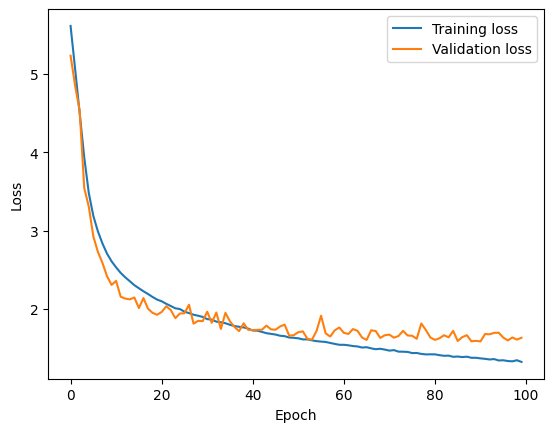

In [60]:
history_df = pd.DataFrame(history.history)

# Plot the training and validation loss
plt.plot(history_df['loss'], label='Training loss')
plt.plot(history_df['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

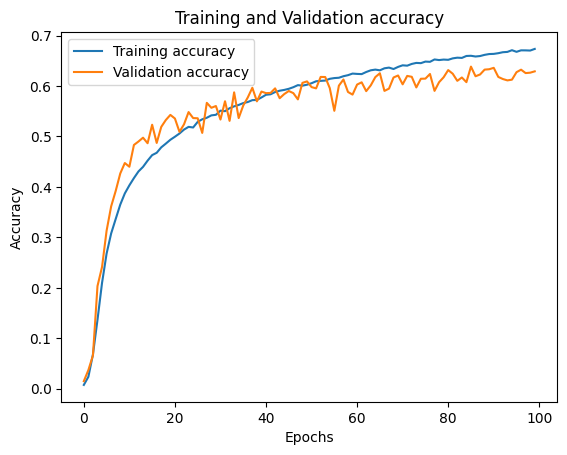

In [61]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [62]:
lstm_model.save("lstm_model2.keras")

In [65]:
lstm_model2 = tf.keras.models.load_model('lstm_model2.keras')

In [67]:
y_pred = lstm_model2.predict(X_test)

591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [68]:
test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6328 - loss: 1.6268
Test Loss: 1.6170759201049805
Test Accuracy: 0.634367048740387


In [69]:
print('Test Data:')
for x, y_true, y_pred_encoded in zip(X_test[:20], y_test[:20], y_pred[:20]):
    pred_label = ORD2SIGN[np.argmax(y_pred_encoded)]
    true_label = ORD2SIGN[y_true]
    print(f'Pred: {pred_label:<20} – True: {true_label}')

Test Data:
Pred: sticky               – True: sticky
Pred: bedroom              – True: before
Pred: dry                  – True: pretty
Pred: hen                  – True: hen
Pred: tomorrow             – True: tomorrow
Pred: up                   – True: up
Pred: blow                 – True: blow
Pred: go                   – True: weus
Pred: jacket               – True: read
Pred: chin                 – True: say
Pred: fish                 – True: zebra
Pred: sad                  – True: sad
Pred: drawer               – True: drawer
Pred: animal               – True: animal
Pred: red                  – True: tomorrow
Pred: pen                  – True: pen
Pred: bath                 – True: donkey
Pred: cheek                – True: cheek
Pred: cow                  – True: cowboy
Pred: cut                  – True: scissors


In [ ]:
y_pred_actual = y_pred.copy()
y_pred = np.argmax(y_pred, axis=1).tolist()

In [72]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6343670618120237


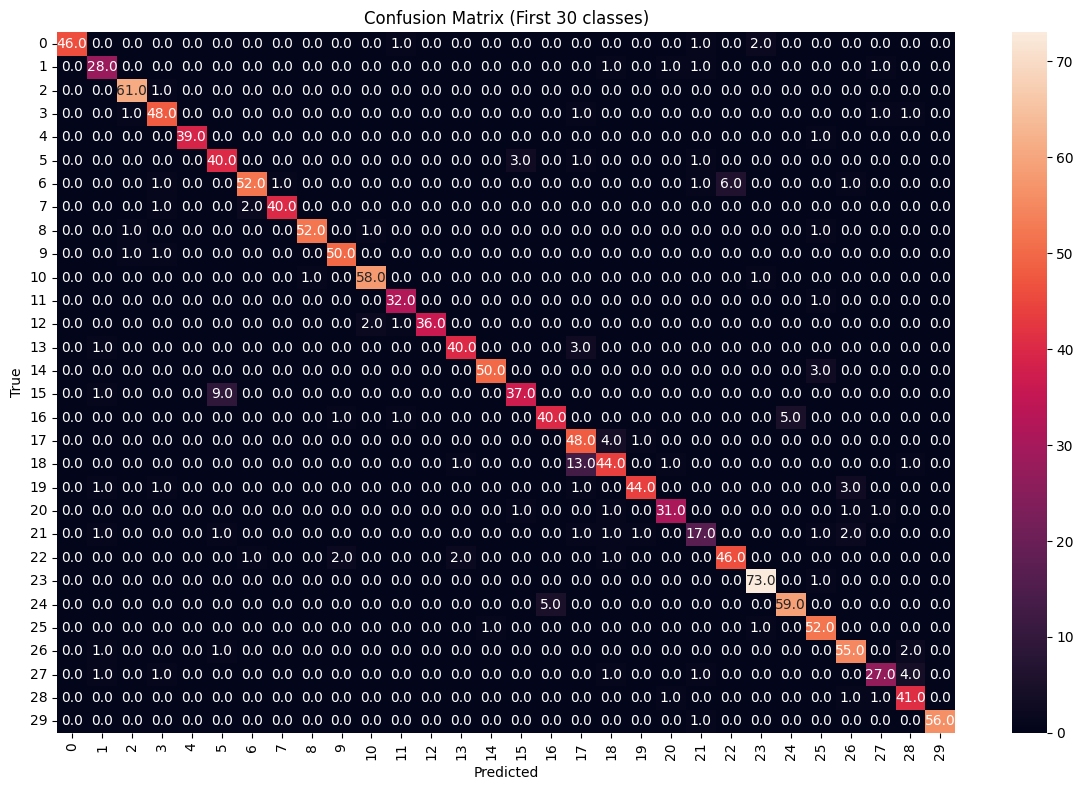

In [73]:
cm = confusion_matrix(y_test, y_pred)

class_range = slice(0, 30)

plt.figure(figsize=(12, 8))
sns.heatmap(cm[class_range, class_range], annot=True, fmt='.1f')

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (First 30 classes)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()
